1/1 [==============================] - 0s 216ms/step


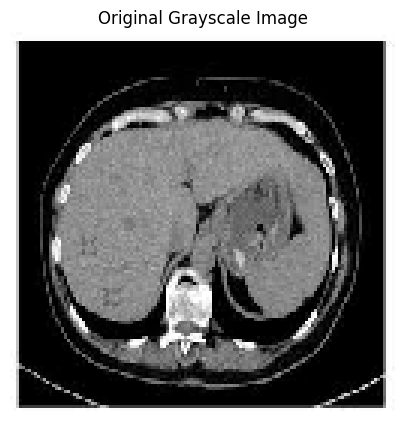

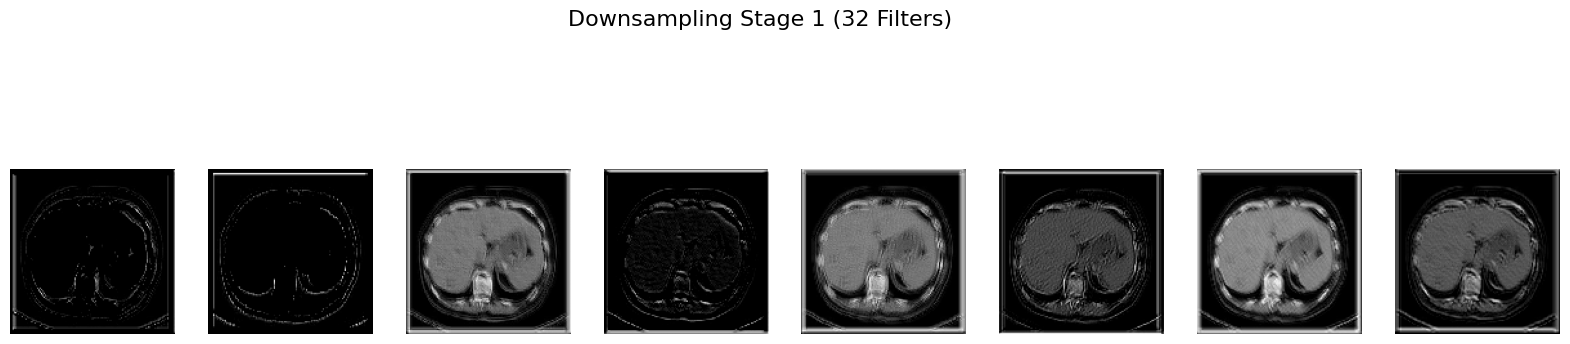

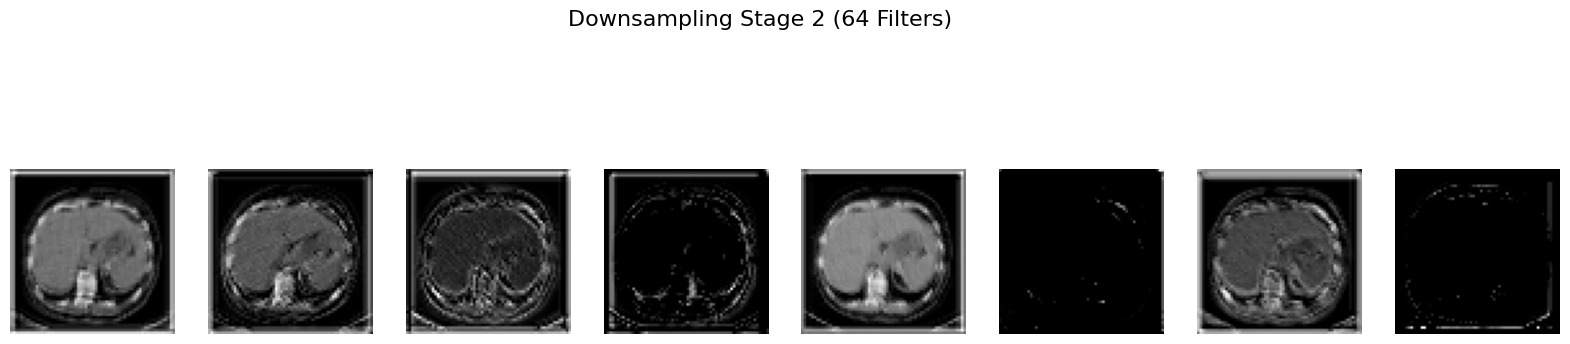

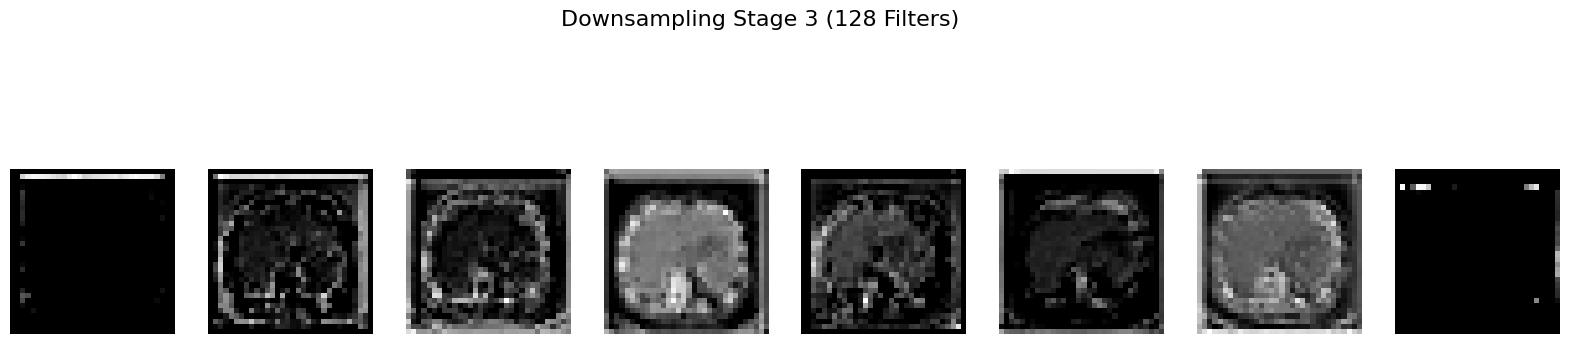

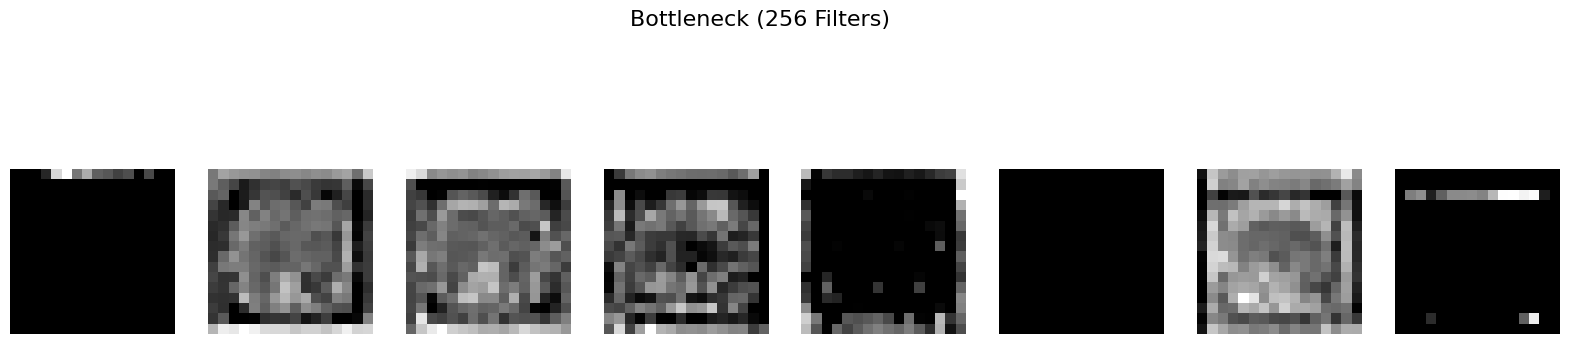

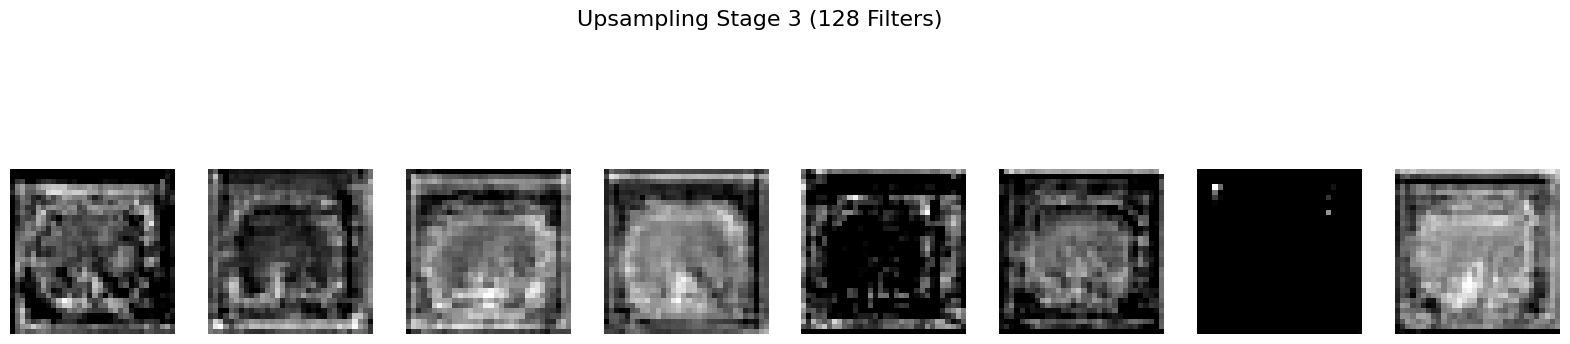

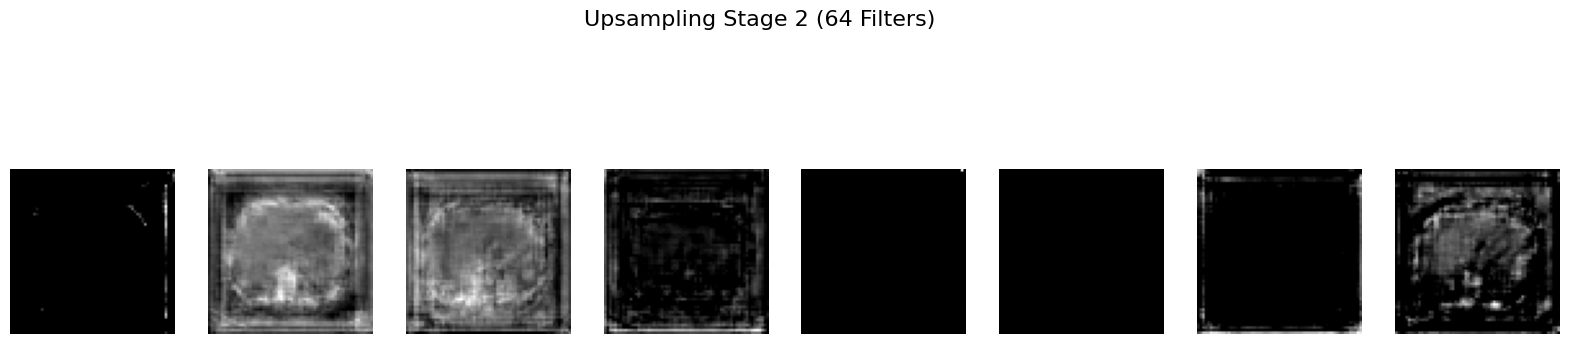

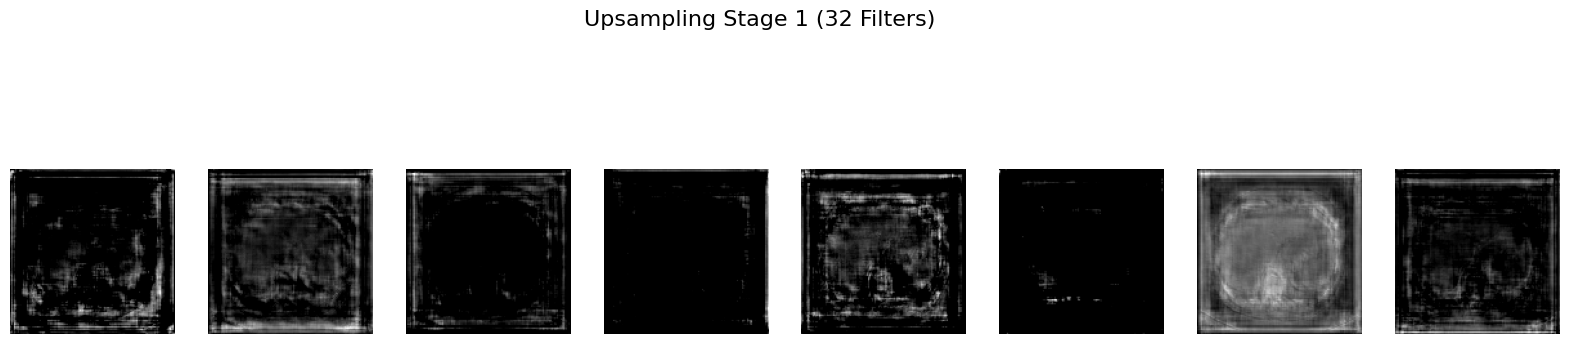

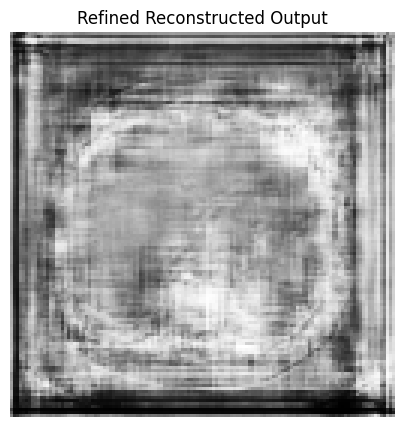

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Add, Concatenate
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Custom initializer with seed
initializer = tf.keras.initializers.HeNormal(seed=SEED)

# Function to define a residual block
def residual_block(input_tensor, filters, kernel_size=(3, 3), strides=(1, 1)):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', activation='relu',
               kernel_initializer=initializer)(input_tensor)
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', activation=None,
               kernel_initializer=initializer)(x)
    shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same',
                      kernel_initializer=initializer)(input_tensor)
    x = Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

# U-Net Architecture
def unet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder (Downsampling with residual layers)
    conv1 = residual_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = residual_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = residual_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck (Residual Block)
    bottleneck = residual_block(pool3, 256)

    # Decoder (Upsampling without residual layers)
    upconv3 = UpSampling2D(size=(2, 2))(bottleneck)
    concat3 = Concatenate()([upconv3, conv3])
    deconv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(concat3)

    upconv2 = UpSampling2D(size=(2, 2))(deconv3)
    concat2 = Concatenate()([upconv2, conv2])
    deconv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(concat2)

    upconv1 = UpSampling2D(size=(2, 2))(deconv2)
    concat1 = Concatenate()([upconv1, conv1])
    deconv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(concat1)

    outputs = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=initializer)(deconv1)  # Final output layer

    # Create the U-Net model
    model = Model(inputs=inputs, outputs=[conv1, conv2, conv3, bottleneck, deconv3, deconv2, deconv1, outputs])
    return model

# Load and preprocess the grayscale image
img_path = '/home/icmr/Pictures/CT.jpeg'  # Replace with your grayscale image path
original_img = load_img(img_path, color_mode='grayscale', target_size=(128, 128))
img_array = img_to_array(original_img) / 255.0  # Normalize pixel values to [0, 1]
input_img = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Define the U-Net model
input_shape = (128, 128, 1)  # Input shape for grayscale images
model = unet_model(input_shape)

# Compile the model (optional, in case of training)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Placeholder for training the model (uncomment if training data is available)
# train_images = ...  # Load your training images here
# model.fit(train_images, train_images, epochs=10, batch_size=16)

# Get feature maps from the U-Net
feature_maps = model.predict(input_img)

# Unpack feature maps
down1, down2, down3, bottleneck, up3, up2, up1, final_output = feature_maps

# Function to visualize feature maps
def visualize_feature_maps(feature_maps, title, num_filters=8):
    num_filters = min(num_filters, feature_maps.shape[-1])  # Limit the number of filters to display
    plt.figure(figsize=(20, 5))
    for i in range(num_filters):
        plt.subplot(1, num_filters, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

# Display original grayscale image
plt.figure(figsize=(5, 5))
plt.imshow(original_img, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')
plt.show()

# Visualize feature maps at each stage
visualize_feature_maps(down1, "Downsampling Stage 1 (32 Filters)")
visualize_feature_maps(down2, "Downsampling Stage 2 (64 Filters)")
visualize_feature_maps(down3, "Downsampling Stage 3 (128 Filters)")
visualize_feature_maps(bottleneck, "Bottleneck (256 Filters)")
visualize_feature_maps(up3, "Upsampling Stage 3 (128 Filters)")
visualize_feature_maps(up2, "Upsampling Stage 2 (64 Filters)")
visualize_feature_maps(up1, "Upsampling Stage 1 (32 Filters)")

# Display final output
reconstructed_image = np.clip(final_output[0, :, :, 0], 0, 1)  # Clip the output to [0, 1] range
plt.figure(figsize=(5, 5))
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Refined Reconstructed Output')
plt.axis('off')
plt.show()
